In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import PC, HillClimbSearch, MmhcEstimator
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import time
import warnings

from fedot.core.data.data import InputData
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# Игнорирование возникающих предупреждений.
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\romav\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


<h2>Подготовка данных</h2>

In [2]:
data = pd.read_excel("kaggle/well_log.xlsx", sheet_name=0)
# убираем лишние столбцы
data.drop(columns=['SXO', 'Dtsyn', 'Vpsyn', 'sw new', 'sw new%', 'PHI2', 'ΔVp (m/s)'], inplace=True)
# print(data)

data.head()

,Depth,CALI,CGR,DT,ILD,NPHI,PEF,PHIE,RHOB,RT,SGR,SW,Φda,ΦN,ΦND,Vpreal,ΔVp
0,3154.07,8.85,3.49,58.30,764.96,0.01,5.08,0.01,2.83,803.39,15.36,0.92,0.010811,0.01,0.010413,5.228130,0.124056
1,3154.22,8.89,3.84,58.57,862.66,0.01,4.99,0.01,2.82,923.57,17.78,0.75,0.016216,0.01,0.013472,5.204029,0.122700
2,3154.38,8.92,3.93,58.71,1017.51,0.01,4.90,0.01,2.82,1117.78,19.66,0.63,0.016216,0.01,0.013472,5.191620,0.122004
3,3154.53,8.95,3.77,58.77,1272.45,0.01,4.83,0.01,2.81,1310.53,20.77,0.58,0.021622,0.01,0.016845,5.186320,0.121708
4,3154.68,8.98,3.42,58.81,1369.27,0.01,4.79,0.01,2.81,1418.42,21.09,0.53,0.021622,0.01,0.016845,5.182792,0.121510


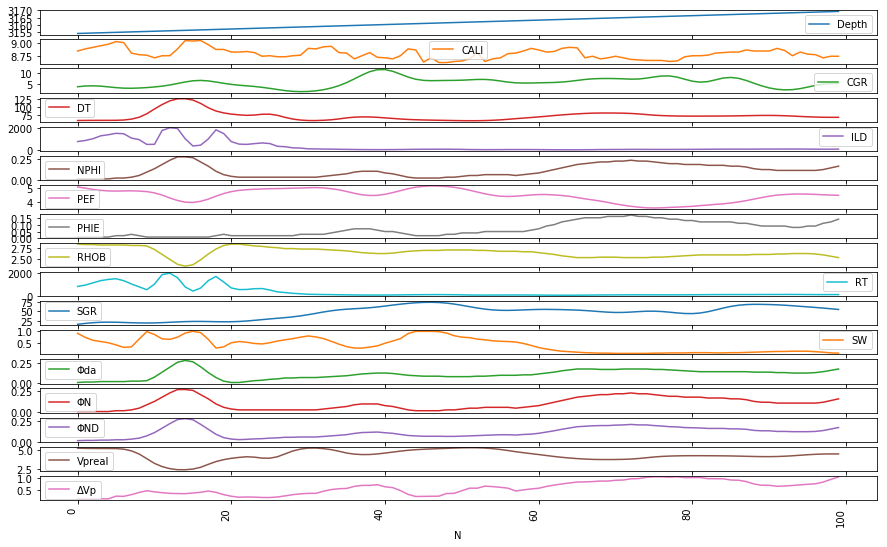

In [3]:
data[:100].plot(subplots=True, figsize=(15, 10))
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [4]:
# рисуем корреляционную матрицу
# corr = data.corr()
# sns.heatmap(corr, annot=True, fmt='.1f', cmap='Blues')
# plt.show()

# обходим массив и создаем недостающие значения глубины (остальные - NaN)
temp_df = pd.DataFrame()

new_str = np.zeros(17)
new_str[:] = np.nan

depth = data.Depth[0]
depths_list = []
while depth <= data.Depth.values[-1]:
    depth = np.round(depth + 0.15, 2)
    depths_list.append(depth)
    if depth not in data.Depth.values:

        # добавляем новое значение для глубины
        new_str[0] = depth  
        str_to_pandas = pd.DataFrame([new_str], columns=list(data.columns))
        temp_df = temp_df.append(str_to_pandas)

print(len(temp_df), "новых значений добавлено")

3470 новых значений добавлено


      index    Depth  CALI   CGR     DT      ILD  NPHI   PEF  PHIE  RHOB  \
0         0  3154.07  8.85  3.49  58.30   764.96  0.01  5.08  0.01  2.83   
1         1  3154.22  8.89  3.84  58.57   862.66  0.01  4.99  0.01  2.82   
2         0  3154.37   NaN   NaN    NaN      NaN   NaN   NaN   NaN   NaN   
3         2  3154.38  8.92  3.93  58.71  1017.51  0.01  4.90  0.01  2.82   
4         0  3154.52   NaN   NaN    NaN      NaN   NaN   NaN   NaN   NaN   
...     ...      ...   ...   ...    ...      ...   ...   ...   ...   ...   
7110      0  3709.22   NaN   NaN    NaN      NaN   NaN   NaN   NaN   NaN   
7111   3643  3709.26  8.13   NaN  57.01     2.87  0.12  3.69  0.12  2.51   
7112      0  3709.37   NaN   NaN    NaN      NaN   NaN   NaN   NaN   NaN   
7113   3644  3709.42  8.11   NaN  56.83     2.61  0.12  3.65  0.12  2.51   
7114      0  3709.52   NaN   NaN    NaN      NaN   NaN   NaN   NaN   NaN   

           RT    SGR    SW       Φda    ΦN       ΦND    Vpreal       ΔVp  
0      803.3

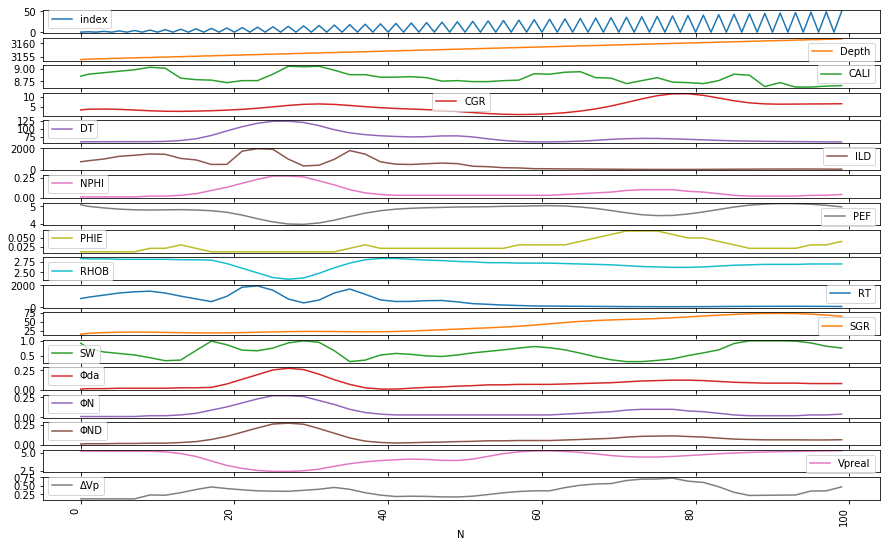

In [5]:
data = data.append(temp_df).sort_values(by=['Depth'])
data.reset_index(inplace=True)
print(data)

data = data.interpolate(method='index')

data[:100].plot(subplots=True, figsize=(15, 10))
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

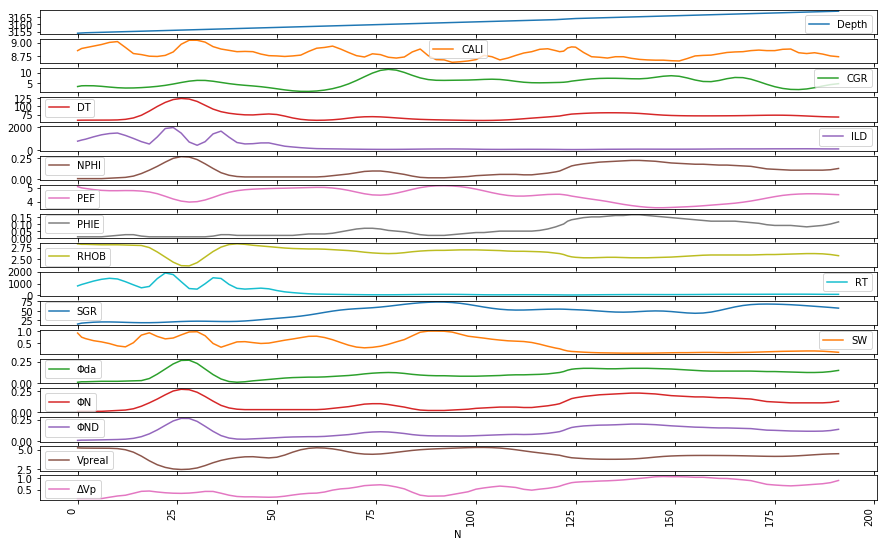

        Depth   CALI     CGR      DT       ILD  NPHI    PEF  PHIE   RHOB  \
0     3154.07  8.850   3.490  58.300   764.960  0.01  5.080  0.01  2.830   
1     3154.22  8.890   3.840  58.570   862.660  0.01  4.990  0.01  2.820   
2     3154.37  8.905   3.885  58.640   940.085  0.01  4.945  0.01  2.820   
4     3154.52  8.935   3.850  58.740  1144.980  0.01  4.865  0.01  2.815   
6     3154.67  8.965   3.595  58.790  1320.860  0.01  4.810  0.01  2.810   
...       ...    ...     ...     ...       ...   ...    ...   ...    ...   
7106  3708.92  8.235  18.420  58.750     3.105  0.12  3.670  0.12  2.495   
7108  3709.07  8.220  18.420  57.870     3.050  0.12  3.705  0.12  2.505   
7110  3709.22  8.160  18.420  57.245     2.935  0.12  3.700  0.12  2.510   
7112  3709.37  8.120  18.420  56.920     2.740  0.12  3.670  0.12  2.510   
7114  3709.52  8.110  18.420  56.830     2.610  0.12  3.650  0.12  2.510   

            RT     SGR     SW       Φda    ΦN       ΦND    Vpreal       ΔVp  
0      80

In [6]:
# после интерполяции удаляем "лишние" старые значения, чтобы остался ряд с шагом .15

inx_list = []
depth = data.Depth[0]
for i in range(1, len(data.Depth)):
    if data.Depth[i] not in depths_list:
        inx_list.append(i)

data = data.drop(index=inx_list)
data = data.drop(columns=["index"])

data[:100].plot(subplots=True, figsize=(15, 10))
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

print(data)
print(data[:25])

data.to_csv('kaggle/well_log_interpolated.csv', index=False)

In [7]:
# Разделение выборки на тренировочную и тестовую.
x_train, x_test = sklearn.model_selection.train_test_split(data, test_size=0.3, random_state=42)

In [15]:
import timeit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
def make_forecast_with_tuning(pipeline, task, cv_folds):
    """
    Function for predicting values in a time series
    :param pipeline: TsForecastingPipeline object
    :param train_input: InputData for fit
    :param predict_input: InputData for predict
    :param task: Ts_forecasting task
    :param cv_folds: number of folds for validation
    :return predicted_values: numpy array, forecast of model
    """

    # Fit it
    start_time = timeit.default_timer()
    pipeline.fit_from_scratch(x_train)
    amount_of_seconds = timeit.default_timer() - start_time

    print(f'\nIt takes {amount_of_seconds:.2f} seconds to train pipeline\n')

    # Predict
    predicted_values = pipeline.predict(x_test)
    old_predicted_values = predicted_values.predict

    pipeline_tuner = PipelineTuner(pipeline=pipeline, task=task,
                                   iterations=10)
    pipeline = pipeline_tuner.tune_pipeline(input_data=x_train,
                                            loss_function=mean_squared_error,
                                            loss_params={'squared': False},
                                            cv_folds=cv_folds,
                                            validation_blocks=3)

    # Fit pipeline on the entire train data
    pipeline.fit_from_scratch(x_train)
    # Predict
    predicted_values = pipeline.predict(x_test)
    new_predicted_values = predicted_values.predict

    return old_predicted_values, new_predicted_values


In [10]:
def get_complex_pipeline():
    """
    Pipeline looking like this
    smoothing - lagged - ridge \
                                \
                                 ridge -> final forecast
                                /
                lagged - ridge /
    """

    # First level
    node_smoothing = PrimaryNode('smoothing')

    # Second level
    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_smoothing])
    node_lagged_2 = PrimaryNode('lagged')

    # Third level
    node_ridge_1 = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_ridge_2 = SecondaryNode('ridge', nodes_from=[node_lagged_2])

    # Fourth level - root node
    node_final = SecondaryNode('ridge', nodes_from=[node_ridge_1, node_ridge_2])
    pipeline = Pipeline(node_final)

    return pipeline

In [11]:
def get_ar_pipeline():
    """
    Function return graph with AR model
    """

    node_ar = PrimaryNode('ar')
    pipeline = Pipeline(node_ar)

    return pipeline

In [12]:
def prepare_input_data(len_forecast, train_data_features, train_data_target,
                       test_data_features):
    """ Return prepared data for fit and predict
    :param len_forecast: forecast length
    :param train_data_features: time series which can be used as predictors for train
    :param train_data_target: time series which can be used as target for train
    :param test_data_features: time series which can be used as predictors for prediction
    :return train_input: Input Data for fit
    :return predict_input: Input Data for predict
    :return task: Time series forecasting task with parameters
    """

    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    train_input = InputData(idx=np.arange(0, len(train_data_features)),
                            features=train_data_features,
                            target=train_data_target,
                            task=task,
                            data_type=DataTypesEnum.ts)

    start_forecast = len(train_data_features)
    end_forecast = start_forecast + len_forecast
    predict_input = InputData(idx=np.arange(0, end_forecast),
                              features=np.concatenate([train_data_features, test_data_features]),
                              target=None,
                              task=task,
                              data_type=DataTypesEnum.ts)

    return train_input, predict_input, task

In [13]:
def run_experiment_with_tuning(time_series, with_ar_pipeline=False, len_forecast=250,
                               cv_folds=None):
    """ Function with example how time series forecasting can be made
    :param time_series: time series for prediction
    :param with_ar_pipeline: is it needed to use pipeline with AR model or not
    :param len_forecast: forecast length
    """

    # Let's divide our data on train and test samples
    train_data = time_series[:-len_forecast]
    test_data = time_series[-len_forecast:]

    # Source time series
    task = prepare_input_data(len_forecast=len_forecast,
                                                          train_data_features=train_data,
                                                          train_data_target=train_data,
                                                          test_data_features=train_data)

    # Get graph with several models and with arima pipeline
    if with_ar_pipeline:
        pipeline = get_ar_pipeline()
    else:
        pipeline = get_complex_pipeline()

    old_predicted, new_predicted = make_forecast_with_tuning(pipeline, train_input,
                                                             predict_input, task,
                                                             cv_folds)

    old_predicted = np.ravel(np.array(old_predicted))
    new_predicted = np.ravel(np.array(new_predicted))
    test_data = np.ravel(test_data)

    mse_before = mean_squared_error(test_data, old_predicted, squared=False)
    mae_before = mean_absolute_error(test_data, old_predicted)
    print(f'RMSE before tuning - {mse_before:.4f}')
    print(f'MAE before tuning - {mae_before:.4f}\n')

    mse_after = mean_squared_error(test_data, new_predicted, squared=False)
    mae_after = mean_absolute_error(test_data, new_predicted)
    print(f'RMSE after tuning - {mse_after:.4f}')
    print(f'MAE after tuning - {mae_after:.4f}\n')

    pipeline.print_structure()
    plt.plot(range(0, len(time_series)), time_series, label='Actual time series')
    plt.plot(range(len(train_data), len(time_series)), old_predicted, label='Forecast before tuning')
    plt.plot(range(len(train_data), len(time_series)), new_predicted, label='Forecast after tuning')
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
# Запуск.
run_experiment_with_tuning(data,
                               with_ar_pipeline=False,
                               len_forecast=50,
                               cv_folds=2)

Fit pipeline from scratch


TypeError: '(slice(None, None, None), 0)' is an invalid key